# Fase 2: Integración de ambos modelos

## Segmentación palpebral y estimación de hemoglobina mediante pipeline unificado

En esta segunda fase del proyecto **ANEA (Anemia Non-Invasive Estimation App)** integramos los dos modelos desarrollados previamente:

1. El modelo de **segmentación** basado en **SegFormer**, responsable de identificar la región de la **conjuntiva palpebral**.
2. El modelo **Xception**, encargado de estimar la **concentración de hemoglobina (Hb)** a partir de la región segmentada.

Esta integración permite automatizar el proceso completo de estimación no invasiva de hemoglobina a partir de una sola fotografía del ojo, unificando las etapas de segmentación, recorte de región de interés y predicción.

El pipeline fue diseñado para ser ejecutado tanto en entornos locales como en aplicaciones web, y representa la **base funcional del sistema ANEA**, previo a la validación clínica.

---


### 1. Verificar librerías del entorno.

Éstas versiones se verificaron para compatibilidad entre TensorFlow 2.15 y Transformers 4.57.

In [37]:
import tensorflow as tf
import torch, transformers, cv2, numpy as np

print("TensorFlow:", tf.__version__)
print("PyTorch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("OpenCV:", cv2.__version__)


TensorFlow: 2.15.0
PyTorch: 2.9.0+cu128
Transformers: 4.57.1
OpenCV: 4.11.0


### 2. Cargar el modelo de segmentación

Definimos la ruta del modelo, luego cargamos el procesador y el modelo y confirmamos si se ha cargado correctamente.

El modelo base utilizado fue el SegFormer y después se hizo un finetunnig para poder segmentar la conjuntiva palpebral.

In [38]:
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import torch

# Ruta al modelo
model_seg_path = "../models/Palpebral_Segmentation_Augmented/"

# Cargar el procesador y el modelo
processor = AutoImageProcessor.from_pretrained(model_seg_path)
segmentador = AutoModelForSemanticSegmentation.from_pretrained(model_seg_path)

# Confirmar que se cargó correctamente
print("Modelo de segmentación cargado correctamente.")


Modelo de segmentación cargado correctamente.


### 3. Generación de la máscara de segmentación

En esta celda se define la función `obtener_mascara()`, que permite aplicar el modelo de segmentación a una imagen RGB para generar una **máscara binaria**.  
La máscara representa los píxeles identificados como región conjuntival (`1`) frente al fondo (`0`).

El proceso incluye:
- Preprocesamiento de la imagen mediante el *processor* del modelo.
- Inferencia con PyTorch en modo `no_grad()` (sin cálculo de gradientes).
- Conversión de los logits en una máscara binaria basada en el índice de la clase con mayor probabilidad.


In [39]:
import numpy as np
import torch.nn.functional as F

def obtener_mascara(img_rgb: np.ndarray) -> np.ndarray:
    """
    Genera la máscara binaria {0,1} correspondiente a la región conjuntival.
    El resultado se ajusta automáticamente al tamaño original de la imagen.
    """
    # Preprocesamiento de entrada
    inputs = processor(images=img_rgb, return_tensors="pt")

    # Inferencia sin gradientes
    with torch.no_grad():
        logits = segmentador(**inputs).logits  # [1, C, H', W']

    # Reescalar los logits al tamaño original de la imagen
    H, W = img_rgb.shape[:2]
    logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)

    # Obtener la clase más probable por píxel (fondo=0, conjuntiva=1)
    mask_idx = logits.argmax(dim=1).squeeze().cpu().numpy().astype(np.uint8)

    # Convertir a binario (1 = conjuntiva, 0 = fondo)
    mask = (mask_idx == 1).astype(np.uint8)

    return mask

print("Función 'obtener_mascara' definida correctamente.")

Función 'obtener_mascara' definida correctamente.


### 4. Aplicación de la máscara sobre la imagen original

En esta celda se define la función `aplicar_mascara()`, encargada de superponer la máscara binaria obtenida previamente sobre la imagen original.  
Esto permite aislar únicamente la **región de la conjuntiva palpebral**, eliminando el resto del contenido visual de la imagen.

El procedimiento consiste en convertir la máscara a formato de 8 bits y aplicar una operación lógica `bitwise_and` entre la imagen y la propia máscara.


In [40]:
import cv2

def aplicar_mascara(img_rgb: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Aplica una máscara binaria sobre una imagen RGB y devuelve
    la región correspondiente a la conjuntiva palpebral.
    Ajusta automáticamente el tamaño de la máscara si difiere del de la imagen.
    """
    # Asegurar que la máscara tenga el mismo tamaño que la imagen
    if mask.shape != img_rgb.shape[:2]:
        mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convertir a uint8 y escalar a 0–255
    mask_uint8 = (mask.astype(np.uint8) * 255)

    # Aplicar la máscara a la imagen original
    region = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_uint8)
    return region

print("Función 'aplicar_mascara' definida correctamente (ajuste de tamaño incluido).")



Función 'aplicar_mascara' definida correctamente (ajuste de tamaño incluido).


### 5. Carga del modelo de estimación de hemoglobina (Xception)

En esta celda se carga el modelo **Xception**, utilizado para la etapa de estimación de hemoglobina a partir de las regiones segmentadas de la conjuntiva palpebral.  
Este modelo fue previamente entrenado y guardado en formato `.h5`, y se carga aquí sin compilación (`compile=False`) para evitar incompatibilidades con la versión actual de TensorFlow.

Al finalizar la ejecución, se muestra la forma de entrada esperada del modelo, que en este caso corresponde a imágenes RGB de **224×224 píxeles**, con tres canales de color.

In [41]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

# Ruta del modelo Xception
model_xcep_path = Path("../models/best_xception_model.h5")

# Cargar el modelo sin compilar (para evitar conflictos)
xception_model = keras.models.load_model(model_xcep_path, compile=False)

# Mostrar la forma de entrada
input_shape = xception_model.input_shape
print("Modelo Xception cargado correctamente.")
print("Forma de entrada esperada:", input_shape)


Modelo Xception cargado correctamente.
Forma de entrada esperada: (None, 224, 224, 3)


### 6. Preparación de la entrada para el modelo Xception

Esta celda define la función `preparar_entrada_xception()`, la cual realiza el preprocesamiento necesario para que la imagen segmentada pueda ser procesada por el modelo **Xception**.

Las operaciones incluyen:
- Redimensionamiento de la región conjuntival al tamaño de entrada requerido por el modelo (224×224 píxeles).
- Normalización de los valores de los píxeles al rango [0,1].
- Expansión de la dimensión de lote (*batch dimension*), de modo que la imagen adquiera la forma (1, 224, 224, 3), que es la esperada por Keras.

El tamaño 224×224 coincide con la entrada esperada del modelo Xception, optimizando consistencia entre entrenamiento y predicción.


In [42]:
def preparar_entrada_xception(region_rgb: np.ndarray, H: int = 224, W: int = 224) -> np.ndarray:
    """
    Redimensiona y normaliza la región segmentada de la conjuntiva
    para que sea compatible con el modelo Xception.
    
    Parámetros:
    - region_rgb: Imagen RGB de la región conjuntival.
    - H, W: Tamaño esperado de entrada del modelo (por defecto 224x224).
    
    Retorna:
    - Arreglo numpy con forma (1, H, W, 3) y valores normalizados [0,1].
    """
    # Redimensionar
    resized = cv2.resize(region_rgb, (W, H), interpolation=cv2.INTER_AREA)
    # Normalizar a rango [0, 1]
    arr = resized.astype(np.float32) / 255.0
    # Añadir dimensión batch
    arr = np.expand_dims(arr, axis=0)
    return arr

print("Función 'preparar_entrada_xception' definida correctamente.")


Función 'preparar_entrada_xception' definida correctamente.


### 7. Integración del pipeline completo de segmentación y estimación

En esta celda se implementa la función `estimar_hemoglobina()`, la cual integra todas las etapas del proceso:

1. **Lectura de la imagen:** carga del archivo y conversión a formato RGB.  
2. **Segmentación:** generación de la máscara mediante el modelo de segmentación.  
3. **Extracción de la región de interés:** aplicación de la máscara sobre la imagen original.  
4. **Preprocesamiento:** redimensionamiento y normalización para la entrada del modelo Xception.  
5. **Estimación:** cálculo del valor de hemoglobina o de la probabilidad de anemia según la salida del modelo.

El resultado se devuelve en forma de diccionario con la información de tipo de salida, valor numérico, máscara y región segmentada.

In [43]:
import numpy as np

def estimar_hemoglobina(img_path: str):
    """
    Ejecuta el pipeline completo de segmentación y estimación de hemoglobina.
    
    Parámetro:
    - img_path: ruta de la imagen a analizar.
    
    Retorna:
    - Diccionario con:
        tipo   → tipo de salida (prob_anemia o hb_g_dl)
        valor  → valor numérico de la estimación
        mask   → máscara binaria generada
        region → imagen de la región conjuntival
    """
    # 1) Leer imagen y convertir a RGB
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {img_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # 2) Obtener máscara y aplicar
    mask = obtener_mascara(rgb)
    region = aplicar_mascara(rgb, mask)

    # 3) Preparar imagen para Xception
    x_in = preparar_entrada_xception(region, 224, 224)

    # 4) Predicción con el modelo Xception
    y = xception_model.predict(x_in, verbose=0)
    y = np.array(y)

    # 5) Interpretación del resultado
    if y.ndim == 2 and y.shape[1] == 1:
        val = float(y[0, 0])
        if 0.0 <= val <= 1.0:
            tipo, valor_estimado = "prob_anemia", val
        else:
            tipo, valor_estimado = "hb_g_dl", val
    elif y.ndim == 2 and y.shape[1] == 2:
        prob_anemia = float(y[0, 1])
        tipo, valor_estimado = "prob_anemia", prob_anemia
    else:
        tipo, valor_estimado = "hb_g_dl", float(y.reshape(-1)[0])

    return {"tipo": tipo, "valor": valor_estimado, "mask": mask, "region": region}

print("Función 'estimar_hemoglobina' definida correctamente.")


Función 'estimar_hemoglobina' definida correctamente.


### 8. Prueba del pipeline de segmentación y estimación de hemoglobina

En esta celda se realiza la primera prueba completa del sistema, utilizando la imagen **Imagen_Prueba.jpg** ubicada en la carpeta `data/`.

El proceso ejecuta las siguientes etapas:
- Aplicación del modelo de segmentación para generar la máscara de la conjuntiva.
- Extracción de la región segmentada.
- Procesamiento de dicha región mediante el modelo Xception para obtener la estimación final.
- Visualización simultánea de la imagen original, la máscara generada y la región segmentada.

Finalmente, se imprime el tipo de salida (`prob_anemia` o `hb_g_dl`) junto con el valor estimado.
- El valor estimado corresponde a la concentración de hemoglobina en g/dL obtenida por el modelo Xception.


Tipo de salida: hb_g_dl
Valor estimado: 7.556284427642822


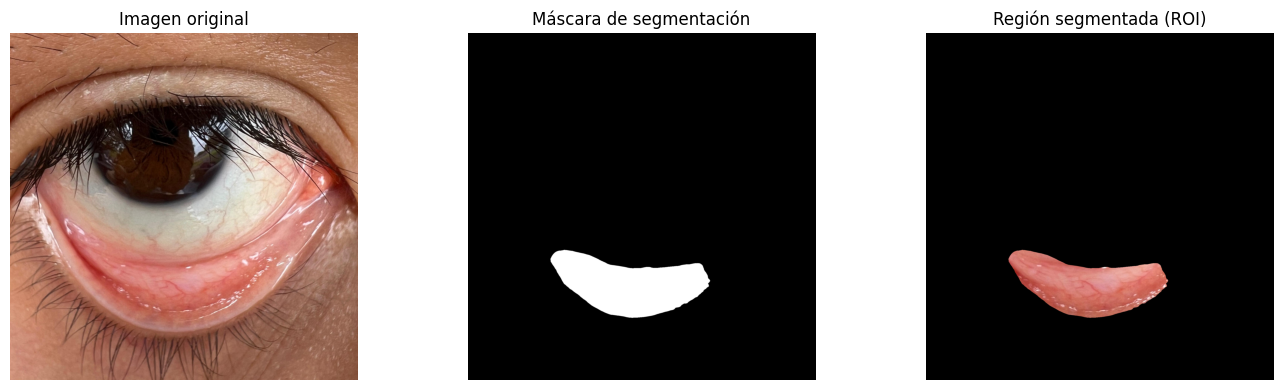

In [44]:
from pathlib import Path
import matplotlib.pyplot as plt
# Ruta de la imagen de prueba
img_test = Path("../data/Imagen_Prueba.jpg")

# Ejecución del pipeline
resultado = estimar_hemoglobina(str(img_test))

# Mostrar tipo y valor estimado
print("Tipo de salida:", resultado["tipo"])
print("Valor estimado:", resultado["valor"])

# Visualización de resultados
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Imagen original
bgr = cv2.imread(str(img_test))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
axs[0].imshow(rgb)
axs[0].set_title("Imagen original")
axs[0].axis("off")

# Máscara
axs[1].imshow(resultado["mask"], cmap="gray")
axs[1].set_title("Máscara de segmentación")
axs[1].axis("off")

# Región segmentada
axs[2].imshow(resultado["region"])
axs[2].set_title("Región segmentada (ROI)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


### 9. Validación de la segmentación

En esta celda se implementa una función que evalúa la calidad de la segmentación generada.  
La función `validar_segmentacion()` calcula la proporción de píxeles clasificados como conjuntiva (valor 1) respecto al total de la imagen.  

Si la proporción es menor a un umbral (por defecto 0.0085, equivalente al 0.85%), se considera que la segmentación fue insuficiente y se solicita repetir la captura de la imagen.

Esto permite evitar errores en la estimación cuando la región conjuntival no se detecta correctamente.


In [45]:
def validar_segmentacion(mask, umbral_min=0.0085):
    """
    Verifica si la segmentación detectó suficiente área de conjuntiva.
    Retorna True si es válida, False si debe repetirse la captura.
    """
    proporcion = np.mean(mask > 0)
    print(f"Porcentaje de píxeles detectados como conjuntiva: {proporcion:.4f}")
    return proporcion >= umbral_min


### 10. Interpretación clínica del resultado  

En esta sección se define la función `interpretar_resultado()`, encargada de traducir el valor estimado de hemoglobina en una **categoría clínica** (por ejemplo, *anemia leve*, *moderada*, *grave* o *normal*), de acuerdo con los valores de referencia establecidos por la **Organización Mundial de la Salud (OMS)**.  

El modelo utiliza únicamente las categorías **“Hombre”** y **“Mujer”** adultas, ya que el conjunto de datos empleado para entrenar el modelo **Xception** contiene exclusivamente imágenes de personas adultas (sin casos pediátricos ni embarazadas).  

Anteriormente se consideró aplicar un **factor de compensación** (>1) para corregir la tendencia del modelo a **subestimar los valores de hemoglobina** al compararse con mediciones de laboratorio en población mexicana. Sin embargo, este ajuste se descartó en la versión actual para mantener la **integridad del modelo original**, y se documenta como una **limitación conocida** que será abordada en la etapa de validación clínica (Fase 4).  

La función devuelve tres elementos:  
- **estado** → Clasificación clínica (ej. “Anemia moderada”)  
- **color** → Indicador visual asociado (verde, amarillo, naranja o rojo)  
- **valor_ajustado** → Valor final de hemoglobina utilizado para la interpretación (sin compensación adicional)  

In [46]:
def interpretar_resultado(valor, sexo, edad):
    """
    Interpreta el valor estimado de hemoglobina considerando sexo y edad.
    Devuelve: estado, color, valor_ajustado.
    
    Parámetros:
        valor : float -> valor estimado por el modelo
        sexo  : str   -> 'Hombre', 'Mujer'
        edad  : int   -> edad del paciente (opcional para niños)
    """
    #factor_compensacion = 1.25  # Factor de compensación empírica
    factor_compensacion = 1
    valor_ajustado = valor * factor_compensacion   

    # --- 1. Casos especiales: valores fuera de rango físico ---
    if valor_ajustado < 4:
        return "Medición no válida (repetir captura)", "gray", valor_ajustado
    if valor_ajustado > 20:
        return "Valor atípico (revisar iluminación o imagen)", "gray", valor_ajustado

    # --- 2. Reglas clínicas según la tabla ---
    # Mujeres adultas
    if sexo.lower() in ["mujer", "femenino"]:
        if valor_ajustado < 8:
            return "Anemia grave", "red", valor_ajustado
        elif valor_ajustado < 11:
            return "Anemia moderada", "orange", valor_ajustado
        elif valor_ajustado < 12.1:
            return "Anemia leve", "yellow", valor_ajustado
        elif valor_ajustado <= 15.1:
            return "Normal", "green", valor_ajustado
        else:
            return "Valor atípico", "gray", valor_ajustado

    # Hombres adultos
    elif sexo.lower() in ["hombre", "masculino"]:
        if valor_ajustado < 8:
            return "Anemia grave", "red", valor_ajustado
        elif valor_ajustado < 10:
            return "Anemia moderada", "orange", valor_ajustado
        elif valor_ajustado < 13.8:
            return "Anemia leve", "yellow", valor_ajustado
        elif valor_ajustado <= 17.2:
            return "Normal", "green", valor_ajustado
        else:
            return "Valor atípico", "gray", valor_ajustado

    # Si no coincide ningún caso
    return "Categoría no definida", "gray", valor_ajustado

print(f"Valor ajustado: {valor_ajustado:.2f} g/dL")
print(f"Clasificación: {estado} ({color})")



Valor ajustado: 7.56 g/dL
Clasificación: Anemia grave (red)


### 11. Evaluación final del sistema

Esta celda ejecuta el pipeline completo: segmentación, validación, estimación de hemoglobina y clasificación clínica.  
El flujo aplica los umbrales definidos según el sexo y la edad, mostrando un resultado interpretado con el formato tipo semáforo.

> En esta versión del notebook, los parámetros `sexo` y `edad` se ingresan manualmente para fines de prueba.  
> En la versión web, estos valores serán solicitados al usuario mediante la interfaz antes de realizar la estimación.

In [47]:
resultado = estimar_hemoglobina(str(img_test))
estado, color, valor_ajustado = interpretar_resultado(resultado["valor"], sexo="Hombre", edad=22)
if validar_segmentacion(resultado["mask"]):
    print(f"Clasificación: {estado} ({valor_ajustado:.2f} g/dL)")
else:
    print("Segmentación insuficiente. Vuelva a capturar la imagen.")


Porcentaje de píxeles detectados como conjuntiva: 0.0545
Clasificación: Anemia grave (7.56 g/dL)
